# 3W Dataset proposto por Vargas (2019)

**Links**
  
- **A Realistic and Public Dataset with Rare Undesirable Real Events in Oil Wells** ([link](https://doi.org/10.1016/j.petrol.2019.106223)).
- **Github de referência** ([link](https://github.com/petrobras/3W)).

* **timestamp**: observations timestamps loaded into pandas DataFrame as its index;
* **P-PDG**: pressure variable at the Permanent Downhole Gauge (PDG);
* **P-TPT**: pressure variable at the Temperature and Pressure Transducer (TPT);
* **T-TPT**: temperature variable at the Temperature and Pressure Transducer (TPT);
* **P-MON-CKP**: pressure variable upstream of the production choke (CKP);
* **T-JUS-CKP**: temperature variable downstream of the production choke (CKP);
* **P-JUS-CKGL**: pressure variable upstream of the gas lift choke (CKGL);
* **T-JUS-CKGL**: temperature variable upstream of the gas lift choke (CKGL);
* **QGL**: gas lift flow rate;
* **class**: observations labels associated with three types of periods (normal, fault transient, and faulty steady state).


* **label**: instance label (event type);
* **well**: well name. Hand-drawn and simulated instances have fixed names. Real instances have names masked with incremental id;
* **id**: instance identifier. Hand-drawn and simulated instances have incremental id. Each real instance has an id generated from its first timestamp.

## 1. Introdução

Análise descritiva do 3W Dataset proposto por Vargas (2019).

In [1]:
# Artifício para alcular tempo total do notebook Jupyter
from datetime import datetime 
start_time = datetime.now()

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
from datetime import datetime
from matplotlib.patches import Patch
from pathlib import Path
from multiprocessing.dummy import Pool as ThreadPool
from collections import defaultdict
from natsort import natsorted

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [7]:
data_path = Path('./', 'data')
events_names = {0: 'Normal Operation',
                1: 'Abrupt Increase of BSW',
                2: 'Spurious Closure of DHSV',
                3: 'Severe Slugging',
                4: 'Flow Instability',
                5: 'Rapid Productivity Loss',
                6: 'Quick Restriction in PCK',
                7: 'Scaling in PCK',
                8: 'Hydrate in Production Line'
               }
columns = ['P-PDG',
           'P-TPT',
           'T-TPT',
           'P-MON-CKP',
           'T-JUS-CKP',
           'P-JUS-CKGL',
           'T-JUS-CKGL',
           'QGL',
           'class']

## 3. Quantidade de Instâncias

A tabela a seguir mostra as quantidades de instâncias que compõem o dataset, por tipo de evento e por fonte: instâncias reais, simuladas e desenhadas à mão.

In [8]:
def class_and_file_generator(data_path, real=False, simulated=False, drawn=False):
    """Gerador de lista contendo número da classe e caminho do arquivo de acordo com a fonte da instância."""
    for class_path in data_path.iterdir():
        if class_path.is_dir():
            class_code = int(class_path.stem)
            for instance_path in class_path.iterdir():
                if (instance_path.suffix == '.csv'):
                    if (simulated and instance_path.stem.startswith('SIMULATED')) or \
                       (drawn and instance_path.stem.startswith('DRAWN')) or \
                       (real and (not instance_path.stem.startswith('SIMULATED')) and \
                       (not instance_path.stem.startswith('DRAWN'))):
                        yield class_code, instance_path

In [9]:
# Carrega instâncias por fonte da instância (real, simulada ou desenhada)
real_instances = list(class_and_file_generator(data_path, real=True, simulated=False, drawn=False))
simulated_instances = list(class_and_file_generator(data_path, real=False, simulated=True, drawn=False))
drawn_instances = list(class_and_file_generator(data_path, real=False, simulated=False, drawn=True))

# Dataframe das instância tipo de evento (código e nome) e fonte da instância.
df_class = pd.DataFrame([{'INSTANCE LABEL': str(c) + ' - ' + events_names[c], 'SOURCE': 'REAL'} for c, p in real_instances] + \
                  [{'INSTANCE LABEL': str(c) + ' - ' + events_names[c], 'SOURCE': 'SIMULATED'} for c, p in simulated_instances] + \
                  [{'INSTANCE LABEL': str(c) + ' - ' + events_names[c], 'SOURCE': 'DRAWN'} for c, p in drawn_instances])


df_class_count = df_class.groupby(['INSTANCE LABEL', 'SOURCE']).size().reset_index().pivot(index='SOURCE', columns='INSTANCE LABEL', values=0).fillna(0).astype(int).T
df_class_count = df_class_count.loc[natsorted(df_class_count.index.values)]
df_class_count = df_class_count[['REAL', 'SIMULATED', 'DRAWN']]

df_class_count['TOTAL'] = df_class_count.sum(axis=1)
df_class_count.loc['TOTAL'] = df_class_count.sum(axis=0)
df_class_count

SOURCE                          REAL  SIMULATED  DRAWN  TOTAL
INSTANCE LABEL                                               
0 - Normal Operation             594          0      0    594
1 - Abrupt Increase of BSW         5        114     10    129
2 - Spurious Closure of DHSV      22         16      0     38
3 - Severe Slugging               32         74      0    106
4 - Flow Instability             344          0      0    344
5 - Rapid Productivity Loss       11        439      0    450
6 - Quick Restriction in PCK       6        215      0    221
7 - Scaling in PCK                 5          0     10     15
8 - Hydrate in Production Line     0         81      0     81
TOTAL                           1019        939     20   1978

In [7]:
tags = {'P-PDG':'Pa', 
        'P-TPT':'Pa', 'T-TPT':'degC',
         'P-MON-CKP':'Pa', 'T-JUS-CKP':'degC', 
         'P-JUS-CKGL':'Pa', 'T-JUS-CKGL':'degC',
         'QGL': 'sm^3/s'}

names = ['Pressure at the PDG',
         'Pressure at the TPT',
         'Temperature at the TPT',
         'Pressure upstream of the PCK',
         'Temperature downstream of the PCK',
         'Pressure downstream of the GLCK',
         'Temperature downstream of the GLCK',
         'Gas lift flow rate']

table = pd.DataFrame(index=np.arange(1,len(names)+1))
table.index.name='Number'
table['Tag'] = tags.keys()
table['Name'] = names
table['Unit'] = tags.values()
table

Tag                                Name    Unit
Number                                                        
1            P-PDG                 Pressure at the PDG      Pa
2            P-TPT                 Pressure at the TPT      Pa
3            T-TPT              Temperature at the TPT    degC
4        P-MON-CKP        Pressure upstream of the PCK      Pa
5        T-JUS-CKP   Temperature downstream of the PCK    degC
6       P-JUS-CKGL     Pressure downstream of the GLCK      Pa
7       T-JUS-CKGL  Temperature downstream of the GLCK    degC
8              QGL                  Gas lift flow rate  sm^3/s

# 4. Mapa de Dispersão das Instâncias Reais

A seguir um mapa de dispersão com todas as **instâncias reais**.

In [8]:
def load_instance(instance):
    """Função que carrega cada instância individualmente"""
    class_code, instance_path = instance
    try:
        well, instance_id = instance_path.stem.split('_')
        df = pd.read_csv(instance_path, index_col='timestamp', parse_dates=['timestamp'])
        assert (df.columns == columns).all(), f'Colunas inválidas no arquivo {str(instance_path)}: {str(df.columns.tolist())}'
        df['label'] = class_code
        df['well'] = well
        df['id'] = instance_id
        df = df[['label', 'well', 'id'] + columns]
        return df
    except Exception as e:
        raise Exception(f'Erro ao ler o arquivo {instance_path}: {e}')

In [9]:
def load_instances(instances):
    """Função que usa multiprocessing para carregar diversas instâncias"""
    pool = ThreadPool()
    all_df = []
    try:
        for df in pool.imap_unordered(load_instance, instances):
            all_df.append(df)
    finally:
        pool.terminate()
    df_all = pd.concat(all_df)
    del all_df
    return df_all

In [10]:
# Dataframe de todas as instâncias reais com 14044002 linhas × 12 colunas:
# timestamp, label, well, id, P-PDG, P-TPT, T-TPT ,P-MON-CKP, T-JUS-CKP, P-JUS-CKGL, T-JUS-CKGL, QGL, class
df_real = load_instances(real_instances)

In [11]:
df_real.shape

(14516197, 12)

In [12]:
df_real.head()

label        well              id  P-PDG       P-TPT  \
timestamp                                                                   
2017-02-01 07:01:14      0  WELL-00001  20170201070114    0.0  10014690.0   
2017-02-01 07:01:15      0  WELL-00001  20170201070114    0.0  10014690.0   
2017-02-01 07:01:16      0  WELL-00001  20170201070114    0.0  10014690.0   
2017-02-01 07:01:17      0  WELL-00001  20170201070114    0.0  10014690.0   
2017-02-01 07:01:18      0  WELL-00001  20170201070114    0.0  10014690.0   

                        T-TPT  P-MON-CKP  T-JUS-CKP  P-JUS-CKGL  T-JUS-CKGL  \
timestamp                                                                     
2017-02-01 07:01:14  119.0370  1792808.0   84.38242   1567765.0         NaN   
2017-02-01 07:01:15  119.0369  1799358.0   84.38877   1567765.0         NaN   
2017-02-01 07:01:16  119.0368  1805908.0   84.39512   1567765.0         NaN   
2017-02-01 07:01:17  119.0367  1812459.0   84.40147   1567765.0         NaN   
2017-02-01 07:01:18  119.0365  1819009.0   84.40782   1567766.0         NaN   

                     QGL  class  
timestamp                        
2017-02-01 07:01:14  0.0    0.0  
2017-02-01 07:01:15  0.0    0.0  
2017-02-01 07:01:16  0.0    0.0  
2017-02-01 07:01:17  0.0    0.0  
2017-02-01 07:01:18  0.0    0.0

In [13]:
# df_real.to_parquet('C:\\Users\\User\\Documents\\Doutorado - UFBA\\Papers\\Paper - Journal of Petroleum Science and Engineering\\dataset\\real_instances.parquet.gzip',
#               compression='gzip')

In [13]:
df_real.well.value_counts().sort_index()

well
WELL-00001    2063376
WELL-00002    4529767
WELL-00003     498949
WELL-00004     401888
WELL-00005    1251136
WELL-00006    2593571
WELL-00007      86021
WELL-00008    1008122
WELL-00009       6738
WELL-00010     602029
WELL-00011     109049
WELL-00012      13892
WELL-00013      10218
WELL-00014     701124
WELL-00015      55103
WELL-00016      74333
WELL-00017     423093
WELL-00018      87788
Name: count, dtype: int64

In [14]:
# Busca o início e fim de cada instância por poço/id/classe para os 1025 casos reais
df_time = df_real.reset_index().groupby(['well', 'id', 'label'])['timestamp'].agg(['min', 'max'])

In [15]:
# Dicionários por poço com tempo (tmin, tmax-tmin) e classes por poço.
well_times = defaultdict(list)
well_classes = defaultdict(list)
for (well, instance_id, class_code), (tmin, tmax) in df_time.iterrows():
    well_times[well].append((tmin.toordinal(), (tmax.toordinal() - tmin.toordinal())))
    well_classes[well].append(int(class_code))

In [16]:
# Estabele um códido por poço em ordem numérica.
wells = df_real['well'].unique()
well_code = {w:i for i, w in enumerate(sorted(wells))}

In [17]:
# Gera um gráfico com a localização no tempo de cada instância real por poço e por classe.
cmap = plt.get_cmap('Paired')
my_colors = [cmap(i) for i in [3, 0, 5, 8, 11, 2, 1, 4, 9, 7, 6, 10]]
my_cmap = mcolors.ListedColormap(my_colors, name='my_cmap')
plt.register_cmap(name='my_cmap', cmap=my_cmap)
cmap = plt.get_cmap('my_cmap')

C:\Users\User\AppData\Local\Temp\ipykernel_14080\1589533484.py:5: MatplotlibDeprecationWarning: The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.register(name)`` instead.
  plt.register_cmap(name='my_cmap', cmap=my_cmap)


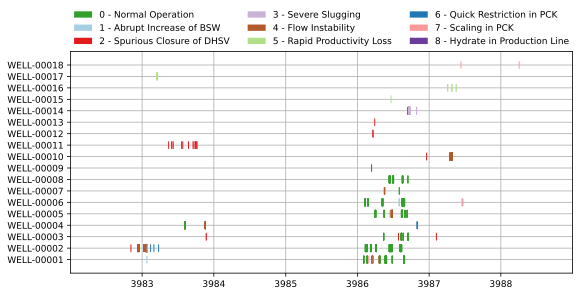

In [45]:
height = 5
border = 2
first_year = np.min(df_time['min']).year
last_year = np.max(df_time['max']).year
plt.rcParams['axes.labelsize'] = 9
plt.rcParams['font.size'] = 9
plt.rcParams['legend.fontsize'] = 9
fig, ax = plt.subplots(figsize=(9, 4))
yticks = []
yticks_labels = []
for well in well_times.keys():
    times = well_times[well]
    class_names = well_classes[well]    
    class_colors = list(map(cmap, class_names))
    well_id = well_code[well]
    yticks.append(well_id * height + height/2 - border/2)
    yticks_labels.append(well)
    ax.broken_barh(times, (well_id * height, height - border), facecolors=class_colors, edgecolors=class_colors)
ax.grid(True)
ax.set_axisbelow(True)
ax.set_yticks(yticks)
ax.set_yticklabels(yticks_labels)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.set_xlim(datetime(first_year, 1, 1).toordinal(), datetime(last_year, 12, 31).toordinal())
legend_colors = [Patch(facecolor=cmap(i), label=str(i) + ' - ' + events_name) for i, events_name in events_names.items()]
ax.legend(frameon=False, handles=legend_colors, loc='upper center', bbox_to_anchor=(0.5, 1.22), ncol=3)
#fig.savefig('figure.pdf', dpi=500, bbox_inches='tight')

# 5. Análise descritiva dos dados faltantes

In [46]:
def calc_stats_instance(instance):
    """Função que carrega cada instância individualmente e analisa os dados
    para contagem de dados faltantes, congelados e não rotulados."""
    _, instance_path = instance
    n_vars_missing = 0
    n_vars_frozen = 0
    try:    
        df = pd.read_csv(instance_path, index_col='timestamp', parse_dates=['timestamp'])
        vars = df.columns[:-1]
        n_vars = len(vars)
        for var in vars:
            if df[var].isnull().all(): 
                n_vars_missing += 1
            u_values = df[var].unique()
            if len(u_values) == 1 and not np.isnan(u_values):
                n_vars_frozen += 1
        n_obs = len(df)
        n_obs_unlabeled = df['class'].isnull().sum()
        return pd.DataFrame({'n_vars':[n_vars], 
                             'n_vars_missing':[n_vars_missing],
                             'n_vars_frozen':[n_vars_frozen],
                             'n_obs':[n_obs],
                             'n_obs_unlabeled':[n_obs_unlabeled]
                            })
    except Exception as e:
        raise Exception(f'Erro ao ler arquivo {instance_path}: {e}')

In [47]:
def calc_stats_instances(instances):
    """Função que usa multiprocessing para calcular as estatísticas de diversas instâncias"""
    pool = ThreadPool()
    all_stats = []
    try:
        for stats in pool.imap_unordered(calc_stats_instance, instances):
            all_stats.append(stats)
    finally:
        pool.terminate()
    df_all_stats = pd.concat(all_stats)
    del all_stats
    return df_all_stats.sum()

In [48]:
global_stats = calc_stats_instances(real_instances+simulated_instances+drawn_instances)

C:\Users\User\AppData\Local\Temp\ipykernel_14080\1317940805.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(instance_path, index_col='timestamp', parse_dates=['timestamp'])


In [49]:
print(f"Variáveis faltantes: {global_stats['n_vars_missing']} de {global_stats['n_vars']} ({100*global_stats['n_vars_missing']/global_stats['n_vars']:.2f}%)")
print(f"Variáveis congeladas: {global_stats['n_vars_frozen']} de {global_stats['n_vars']} ({100*global_stats['n_vars_frozen']/global_stats['n_vars']:.2f}%)")
print(f"Observações não rotuladas: {global_stats['n_obs_unlabeled']} de {global_stats['n_obs']} ({100*global_stats['n_obs_unlabeled']/global_stats['n_obs']:.2f}%)")

Variáveis faltantes: 4660 de 15824 (29.45%)
Variáveis congeladas: 1550 de 15824 (9.80%)
Observações não rotuladas: 635440 de 51385410 (1.24%)


In [50]:
# Calcular tempo total do notebook Jupyter
print(f'Tempo total de execução (hh:mm:ss.ms): {datetime.now() - start_time}')

Tempo total de execução (hh:mm:ss.ms): 0:41:49.897612


# Análise descritiva

In [12]:
# Lista todas as instâncias de todas as classes
all_instances = list(class_and_file_generator(data_path, real=True, simulated=False, drawn=False))

In [13]:
# Importar bibliotecas necessárias
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker


matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = ['CMU Serif', 'Times New Roman']


# Sorteia e lê uma instância aleatória qualquer
random.seed(5)
instancia_sorteada = random.randint(0, len(all_instances) - 1)
df_all_instances = load_instance(all_instances[instancia_sorteada])

# Eixo x é o timestamp, deve ser do tipo datetime
x = pd.to_datetime(df_all_instances.index)

# Eixo y é o valor de cada uma das 9 variáveis
y1 = df_all_instances['P-PDG']
y2 = df_all_instances['P-TPT']
y3 = df_all_instances['T-TPT']
y4 = df_all_instances['P-MON-CKP']
y5 = df_all_instances['T-JUS-CKP']
y6 = df_all_instances['P-JUS-CKGL']
y7 = df_all_instances['T-JUS-CKGL']
y8 = df_all_instances['QGL']
y9 = df_all_instances['class']  # Verifique se é contínua ou categórica


fig, axs = plt.subplots(3, 3, sharex=True)


fig.set_figheight(6)
fig.set_figwidth(10)


def plot_data(ax, x, y, title):
    ax.plot(x, y, 'tab:blue')
    ax.set_title(title)
    ax.grid(True)
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))  

# Plota os dados
plot_data(axs[0, 0], x, y1, 'P-PDG')
plot_data(axs[0, 1], x, y2, 'P-TPT')
plot_data(axs[0, 2], x, y3, 'T-TPT')
plot_data(axs[1, 0], x, y4, 'P-MON-CKP')
plot_data(axs[1, 1], x, y5, 'T-JUS-CKP')
plot_data(axs[1, 2], x, y6, 'P-JUS-CKGL')
plot_data(axs[2, 0], x, y7, 'T-JUS-CKGL')
plot_data(axs[2, 1], x, y8, 'QGL')


if y9.dtype == 'object' or y9.nunique() < 10:
    axs[2, 2].scatter(x, y9, c='tab:blue')  #
    axs[2, 2].set_title('Class')
else:
    plot_data(axs[2, 2], x, y9, 'Class')


for ax in axs.flat:
    ax.xaxis.set_major_locator(ticker.AutoLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y %H:%M'))


fig.autofmt_xdate()


print(f'Exemplo de instância da classe \"{events_names[all_instances[instancia_sorteada][0]]}\"')
print(f'Arquivo \"{all_instances[instancia_sorteada][1]}\"')


plt.show()

# "data\3\WELL-00014_20170922010042.csv"

Exemplo de instância da classe "Severe Slugging"
Arquivo "data\3\WELL-00014_20170922010042.csv"


P-PDG


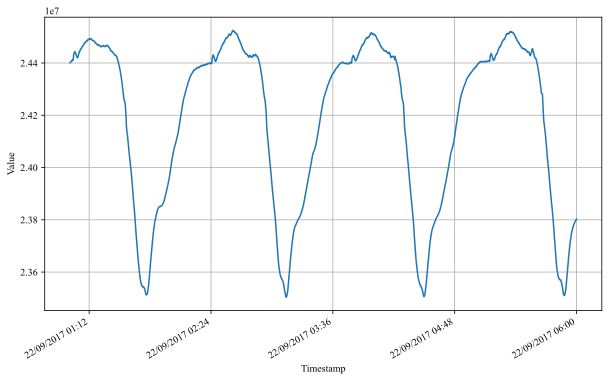

P-TPT


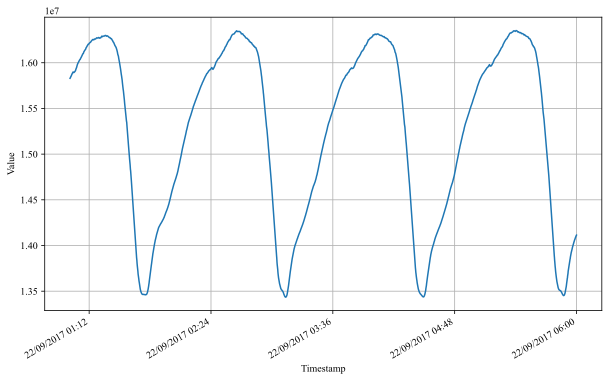

T-TPT


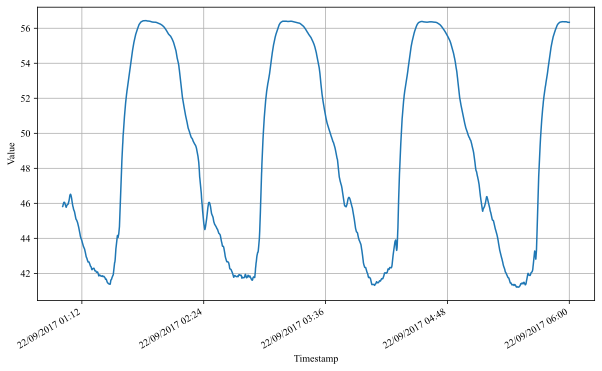

P-MON-CKP


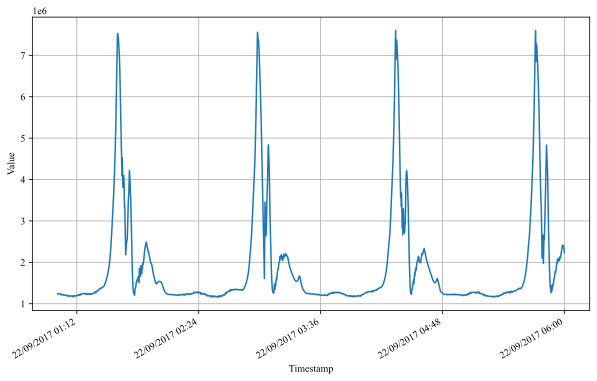

T-JUS-CKP


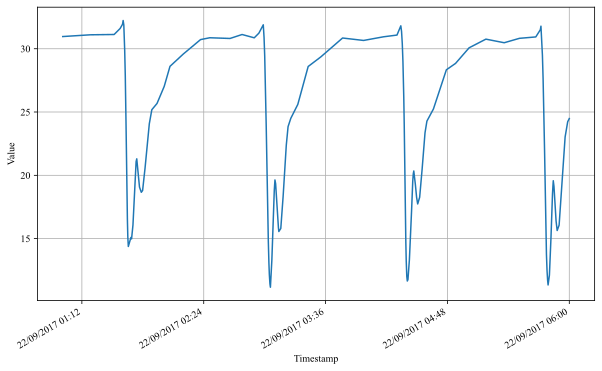

P-JUS-CKGL


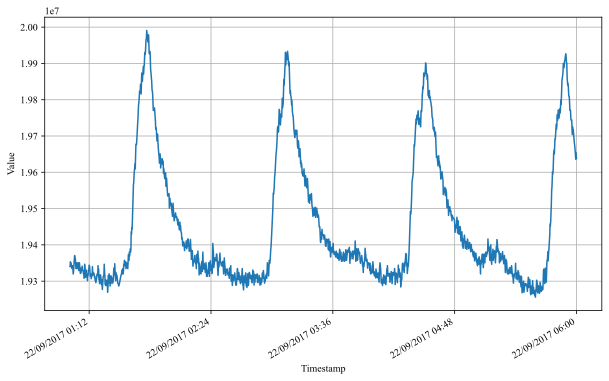

T-JUS-CKGL


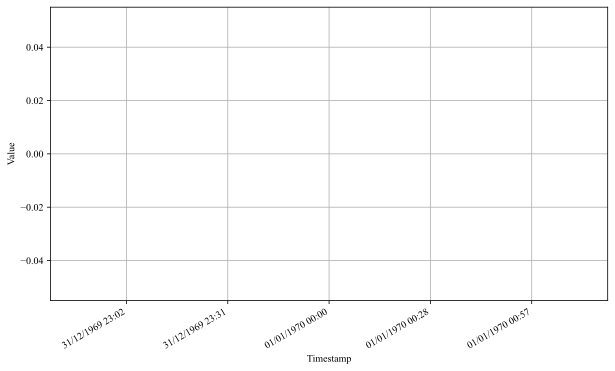

QGL


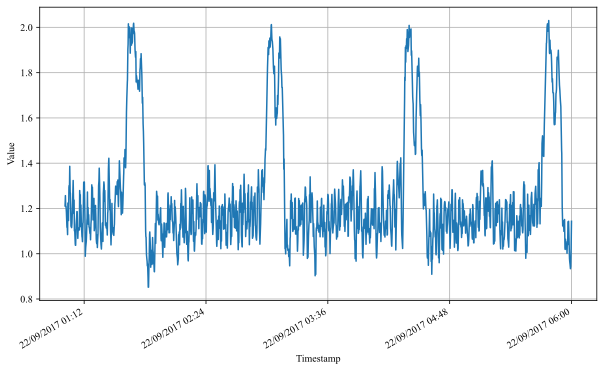

Class


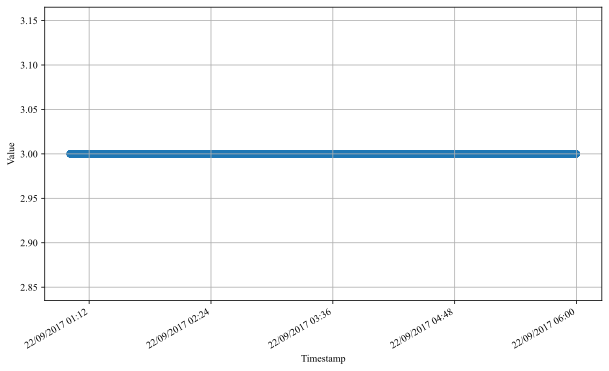

Exemplo de instância da classe "Severe Slugging"
Arquivo "data\3\WELL-00014_20170922010042.csv"


In [16]:
# Configurações de fontes
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = ['CMU Serif', 'Times New Roman']

# Sorteia e lê uma instância aleatória qualquer
random.seed(5)
instancia_sorteada = random.randint(0, len(all_instances) - 1)
df_all_instances = load_instance(all_instances[instancia_sorteada])

# Eixo x é o timestamp, deve ser do tipo datetime
x = pd.to_datetime(df_all_instances.index)

# Eixo y é o valor de cada uma das 9 variáveis
variaveis = {
    'P-PDG': df_all_instances['P-PDG'],
    'P-TPT': df_all_instances['P-TPT'],
    'T-TPT': df_all_instances['T-TPT'],
    'P-MON-CKP': df_all_instances['P-MON-CKP'],
    'T-JUS-CKP': df_all_instances['T-JUS-CKP'],
    'P-JUS-CKGL': df_all_instances['P-JUS-CKGL'],
    'T-JUS-CKGL': df_all_instances['T-JUS-CKGL'],
    'QGL': df_all_instances['QGL'],
    'Class': df_all_instances['class']  # Verifique se é contínua ou categórica
}

# Função para plotar dados
def plot_data(x, y, title, is_class=False):
    plt.figure(figsize=(10, 6))
    if is_class:
        if y.dtype == 'object' or y.nunique() < 10:
            plt.scatter(x, y, c='tab:blue')  # Se for categórica ou com poucos valores únicos
        else:
            plt.plot(x, y, 'tab:blue')  # Se for contínua
    else:
        plt.plot(x, y, 'tab:blue')

    # plt.title(title)
    print(title)
    plt.grid(True)
    plt.gca().xaxis.set_major_locator(ticker.AutoLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y %H:%M'))
    plt.gcf().autofmt_xdate()
    plt.xlabel('Timestamp')
    plt.ylabel('Value')
    plt.show()

# Plota os dados de cada variável separadamente
for nome, dados in variaveis.items():
    is_class = (nome == 'Class')
    plot_data(x, dados, nome, is_class)

print(f'Exemplo de instância da classe \"{events_names[all_instances[instancia_sorteada][0]]}\"')
print(f'Arquivo \"{all_instances[instancia_sorteada][1]}\"')


In [49]:
# import random
# import pandas as pd  
# import matplotlib.pyplot as plt
# import matplotlib.dates as mdates
# import matplotlib.ticker as ticker


# matplotlib.rcParams['font.family'] = 'serif'
# matplotlib.rcParams['font.serif'] = ['CMU Serif', 'Times New Roman']

# # Sorteia e lê uma instância aleatória qualquer
# random.seed(5)
# instancia_sorteada = random.randint(0, len(all_instances) - 1)
# df_all_instances = load_instance(all_instances[instancia_sorteada])

# # Eixo x é o timestamp, deve ser do tipo datetime
# x = pd.to_datetime(df_all_instances.index)

# # Eixo y é o valor de cada uma das 9 variáveis
# y1 = df_all_instances['P-PDG']
# y2 = df_all_instances['P-TPT']
# y3 = df_all_instances['T-TPT']
# y4 = df_all_instances['P-MON-CKP']
# y5 = df_all_instances['T-JUS-CKP']
# y6 = df_all_instances['P-JUS-CKGL']
# y7 = df_all_instances['T-JUS-CKGL']
# y8 = df_all_instances['QGL']
# y9 = df_all_instances['class']  


# fig, axs = plt.subplots(3, 3, sharex=True)

# # Seta altura e largura do gráfico
# fig.set_figheight(6)
# fig.set_figwidth(10)


# def plot_data(ax, x, y, title):
#     ax.plot(x, y, color='blue')  
#     ax.set_title(title, color='black') 
#     ax.grid(True)
#     ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))  #

# # Plota os dados com cor preta
# plot_data(axs[0, 0], x, y1, 'P-PDG')
# plot_data(axs[0, 1], x, y2, 'P-TPT')
# plot_data(axs[0, 2], x, y3, 'T-TPT')
# plot_data(axs[1, 0], x, y4, 'P-MON-CKP')
# plot_data(axs[1, 1], x, y5, 'T-JUS-CKP')
# plot_data(axs[1, 2], x, y6, 'P-JUS-CKGL')
# plot_data(axs[2, 0], x, y7, 'T-JUS-CKGL')
# plot_data(axs[2, 1], x, y8, 'QGL')


# if y9.dtype == 'object' or y9.nunique() < 10:
#     axs[2, 2].scatter(x, y9, color='blue')  # Define a cor preta para o scatter
#     axs[2, 2].set_title('Class', color='black')
# else:
#     plot_data(axs[2, 2], x, y9, 'Class')


# for ax in axs.flat:
#     ax.xaxis.set_major_locator(ticker.AutoLocator())
#     ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y %H:%M'))
#     ax.tick_params(axis='x', colors='black')  
#     ax.tick_params(axis='y', colors='black')  


# fig.autofmt_xdate()


# print(f'Exemplo de instância da classe \"{events_names[all_instances[instancia_sorteada][0]]}\"')
# print(f'Arquivo \"{all_instances[instancia_sorteada][1]}\"')

# plt.show()


In [51]:
df_real['label'].value_counts()

label
0    9903155
4    2462076
3     569152
5     552529
7     466338
1     312136
2     194233
6      56578
Name: count, dtype: int64

In [53]:
df_real['class'].value_counts()

class
0.0      10003293
4.0       2462076
3.0        569152
105.0      317565
107.0      283262
101.0       95658
102.0       65130
7.0         25870
2.0         16100
5.0         13031
6.0         12951
1.0         10417
106.0        6252
Name: count, dtype: int64

In [50]:
pd.crosstab(df_real['well'], df_real['label'])

label             0       1       2       3       4       5      6       7
well                                                                      
WELL-00001  1652442   58468       0   17976  261457       0      0   73033
WELL-00002  3641159   24017    9121       0  807601       0  47869       0
WELL-00003   463543       0   35406       0       0       0      0       0
WELL-00004    85505       0       0       0  307674       0   8709       0
WELL-00005   979611       0       0       0  271525       0      0       0
WELL-00006  2058403  229651       0       0       0       0      0  305517
WELL-00007    14370       0       0       0   71651       0      0       0
WELL-00008  1008122       0       0       0       0       0      0       0
WELL-00009        0       0    6738       0       0       0      0       0
WELL-00010        0       0    9809       0  592220       0      0       0
WELL-00011        0       0  109049       0       0       0      0       0
WELL-00012        0       0   13892       0       0       0      0       0
WELL-00013        0       0   10218       0       0       0      0       0
WELL-00014        0       0       0  551176  149948       0      0       0
WELL-00015        0       0       0       0       0   55103      0       0
WELL-00016        0       0       0       0       0   74333      0       0
WELL-00017        0       0       0       0       0  423093      0       0
WELL-00018        0       0       0       0       0       0      0   87788

In [54]:
pd.crosstab(df_real['class'], df_real['label'])

label        0       1      2       3        4       5      6       7
class                                                                
0.0    9439612  195376  52017       0        0  127930  36319  152039
1.0          0   10417      0       0        0       0      0       0
2.0          0       0  16100       0        0       0      0       0
3.0          0       0      0  569152        0       0      0       0
4.0          0       0      0       0  2462076       0      0       0
5.0          0       0      0       0        0   13031      0       0
6.0          0       0      0       0        0       0  12951       0
7.0          0       0      0       0        0       0      0   25870
101.0        0   95658      0       0        0       0      0       0
102.0        0       0  65130       0        0       0      0       0
105.0        0       0      0       0        0  317565      0       0
106.0        0       0      0       0        0       0   6252       0
107.0        0       0      0       0        0       0      0  283262

In [55]:
df_real.drop_duplicates(subset=['id'], keep='last').groupby("label")["id"].count()

label
0    588
1      5
2     22
3     32
4    344
5     11
6      6
7      5
Name: id, dtype: int64

In [56]:
df_real.isnull().sum()/len(df_real)

label         0.000000
well          0.000000
id            0.000000
P-PDG         0.000580
P-TPT         0.008007
T-TPT         0.008007
P-MON-CKP     0.077959
T-JUS-CKP     0.113279
P-JUS-CKGL    0.071501
T-JUS-CKGL    1.000000
QGL           0.191125
class         0.043775
dtype: float64

In [57]:
df_real['target'] = 1
df_real.loc[(df_real['label']==0)&(df_real['class']==0), "target"] = 0

In [65]:
df = df_real.drop(['T-JUS-CKGL'], axis=1)
df = df.dropna(subset=['class'])
df.shape
# df = df.dropna()

(13880757, 12)

In [66]:
df.isnull().sum()/len(df)

label         0.000000
well          0.000000
id            0.000000
P-PDG         0.000337
P-TPT         0.008008
T-TPT         0.008007
P-MON-CKP     0.080616
T-JUS-CKP     0.080638
P-JUS-CKGL    0.036906
QGL           0.199633
class         0.000000
target        0.000000
dtype: float64

In [67]:
df.target.value_counts(normalize=True)

target
0    0.68005
1    0.31995
Name: proportion, dtype: float64

In [68]:
df['well'].value_counts().sort_index()

well
WELL-00001    2062763
WELL-00002    4519462
WELL-00004     401315
WELL-00005    1251136
WELL-00006    2588721
WELL-00007      86021
WELL-00008    1008122
WELL-00009       6698
WELL-00010     601988
WELL-00011     107719
WELL-00014     701124
WELL-00015      54811
WELL-00016      20465
WELL-00017     383250
WELL-00018      87162
Name: count, dtype: int64

In [69]:
df.dtypes

label           int64
well           object
id             object
P-PDG         float64
P-TPT         float64
T-TPT         float64
P-MON-CKP     float64
T-JUS-CKP     float64
P-JUS-CKGL    float64
QGL           float64
class         float64
target          int64
dtype: object